# Load libraries

In [1]:
import CWTPy
print(CWTPy.__version__)  


%load_ext autoreload
%autoreload 2



# Basic libraries
import pandas as pd
import numpy as np
import sys



# Scipy
import scipy
from scipy import signal
from scipy.linalg import solve
from scipy import constants
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq

# Locate files
import os
from pathlib import Path
from glob import glob

# Plots
from matplotlib import pyplot as plt

#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/turbulator/work/MHDTurbPy")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data
from joblib import Parallel, delayed

""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs

from   SEA import SEA
import three_D_funcs as threeD
import download_data as download

sys.path.insert(1, os.path.join(os.getcwd(), 'functions/3d_anis_analysis_toolboox'))
import collect_wave_coeffs 
import data_analysis 



os.environ["CDF_LIB"] = "/Applications/cdf/cdf/lib"


0.3.5
/Users/turbulator/work/MHDTurbPy/pyspedas/pyspedas/__init__.py


# Download data

In [1116]:

#User defined parameters 

cdf_lib_path            = '/Applications/cdf/cdf/lib'            # You will need to read cdf files. You have to specify the path

""" At this point you NEED credentials for function to work. This is because of the ephemeris data! Let me know if this doesnt work"""


credentials             =      { 'psp':{
                                           'fields': {'username': 'mvelli', 'password': 'flds@psp'},
                                           'sweap' : {'username': 'mvelli', 'password': '2019swe@pd@ta'}}}



settings                =  {
    
                    ###____How to handle data ____###
    
                            'Data_path'              : '/Users/turbulator/work/Data/',  # Path were pyspedas downloads data
                            'save_destination'       : '/Users/turbulator/work/test_hel_bar/WIND/data/',
                            'use_local_data'         :  False,                        # Whether to donwload data(again) or use local data
                            'overwrite_files'        :  1,                            # In case you want to re-do analysis for existing files!
                            'save_all'               :  True,                         # If false it will only keep derived quants. Not timeseries
                            'addit_time_around'      :  1,                            # When loading at first it will return [start_time -addit_time_around [h], end_time + addit_time_around [h]]. The data are cut to the right dates later
                            'gap_time_threshold'     :  5 ,                           # Threshold for large gaps (units of seconds)
    
                       ###____Basics for the intervals ____###   
                            'sc'                     : 'WIND',                         # Choices ['PSP', SOLO, 'HELIOS_A', 'HELIOS_B', 'WIND']
                            'in_rtn'                 :  0,                          # RTN or spacecraft frame ( We will usually use RTN)
                            'multiple_intervals'     :  False,                         # If you only want to check one interval
    
                        ###____Only matters if 'Only_1_interval' ==False. It will essentially download adjacent intervals overlaping by 'Step'____###
                            'duration'               : '4H',                         # Duration of interval
                            'Step'                   : '210min',                     # Move starting point by step 
    
                            'start_date'             : '2021-11-18 12:00', 
                            'end_date'               : '2021-11-18 14:00',
                            'must_have_qtn'          :  1,                            # Dont consider interval if no qtn data. Only matters for PSP & SOLO
                            'Max_par_missing'        :  30,                           # Maximum fraction of missing particle data allowed
                            'particle_mode'          : '9th_perih_cut',               # Only for PSP: either: 'spc', 'span', '9th_perih_cut'
                            'max_PSP_dist'           : 0.4,                           # Maximum PSP distance to consider [au]
                            'part_resol'             : 300,                           # Max resol of plasma data                [ms]
                            'MAG_resol'              : 1,                             # Max resol og magnetic field data        [ms] [<230: Full resol mag data, >230 : 4_sa_per_sec dataset]
                            'upsample_low_freq_ts'   : False,                         # False: Whether to downsample mag data (after applying low-pass filter to make them match the cadence of velocity field data 

                    

                            'cut_in_small_windows'   : {
                                                        'flag'    : False, 
                                                        'njobs'   : 10,
                                                        'Step'    : '5s',          # Cuts each  larger interval in small windows. To avoid loading data again and again (Too slow)
                                                        'duration': '30s'},  
    
                            'Mag_SCAM_PSP': {'flag'         :  False,               # Set False to download fluxgate data
                                             'noise_flag'   :  False,
                                             'noise_removal': {
                                                                'window_size'         : 2**15,
                                                                'avg_length'          : 2,
                                                                'power_threshold'     : 3.0,
                                                                'freq_min'            : 1.0
                                                              }},

                            'sc_pot'     :{
                                            'flag'                 : True,
                                            'fit_interval_minutes' : '10min',
                                            'est_roll_med'         :  False,
                                            'roll_wind_minutes'    : '4min',
                                            'n_sigma_outliers'     : 3
                                          },
    
                            'E_field'    :  {'flag'                 : False,
                                             'cadence_seconds'      : 6,
                                             'fit_interval_minutes' : 4,
                                             'stride_minutes'       : 0.1,
                                             'min_correlation'      : 0.8
                                             },
    
                            'coherence_analysis' : {'flag'                  : False,
                                                    'method'                : {'min_var': ['B'], 
                                                                               'TN_only': ['B', 'E']},
                                                    'nv'                    : 8,
                                                    'alpha'                 : 3,
                                                    'per_thresh'            : 80,
                                                    'par_thresh'            : 10,
                                                    'coh_th'                : 0.7,
                                                    'num_efoldings'         : 3,
                                                    'njobs'                 : 10,
                                                    'est_mod'               : True,
                                                    'estimate_local_V'      : False,
                                                    
                                                    'do_coherence_analysis' : True,
                                                    'estimate_PSDs'         : True,
                                                    'estimate_coh_coeffs'   : True,
                                                    'estimate_comp'         : True,
                                                    'return_coeffs'         : False,
                                                    'est_sfuncs'            : False,
                                                    'max_qorder'            : 8
                            },
    
                            'PSDs'               : {'flag'                  : False},
                            'struc_funcs'        : {'flag'                  : False},
    
                            'npt_struc_funcs'    : {'flag'                  : False,
                                                    'five_points_sfunc'     : True,
                                                    'return_Bmod'           : True,
                                                    'dt_step'               : 0.25,
                                                    'est_sfuncs'            : False,
                                                    'max_qorder'            : 8
                            },

                     ###____Additional diagnostics ____###  
    
                            'estimate_derived_param' : True,
                            'rol_window'             : '60min',                          # When estimating fluctuations, size of window (centered around -w/2 -w/2
                            'apply_hampel'           : False,                         # Use hampelfilter to despike plasma data
                            'hampel_params'          : {'w':200, 'std':3},
                                                                                      # True : Upsample velocity field data
    
                            'estimate_psd_b'         : 1,                             # Estimate magentic field powes spectral density (keep false)
                            'estimate_psd_v'         : 1,                             # Estimate velocity field powes spectral density (keep false)
                            'est_PSD_components'     : 1,
                            'smooth_psd'             : False,
                            'Big_Gaps'               :{
                                                        'E_big_gaps'      : 10,
                                                        'SC_pot_big_gaps' : 10,
                                                        'Mag_big_gaps'    : 500,
                                                        'Par_big_gaps'    : 500,           # A file will be returned where gaps in the timeseries (larger than
                                                        'QTN_big_gaps'    : 10,          # those specified here [s]) are shown. This will enable the user to 
                                                                                       # omit the gappy data later
                                                        }                           
                            } 


# You can chnage those if more data are needed. Check /downloading_helpers/ PSP or SOLO to find default data to be downloaded
if settings['sc'] == "PSP":
    
    if settings['in_rtn']:
        vars_2_downnload = {
                            'mag'    : None, 
                            'span'   : None,
                            'span-a' : None,
                            'spc'    : None, 
                            'qtn'    : None,
                            'E_field': settings['E_field']['flag'],
                            'sc_pot' : settings['sc_pot']['flag'],
                            'ephem'  : None}
    else:
        vars_2_downnload        = {  
                                    'mag'     : ['B_SC'],
                                    'span'    : ['DENS',  'VEL_SC', 'TEMP' , 'SUN_DIST'],
                                    'span-a'  : None,
                                    'spc'     : ['np_moment', 'wp_moment', 'vp_moment_SC','sc_pos_HCI'],
                                    'qtn'     : ['electron_density'],
            
                                    'E_field' : settings['E_field']['flag'],
                                    'sc_pot'  : settings['sc_pot']['flag'],
            
            
                                    'ephem'   : None}      

elif settings['sc'] == "SOLO":
    vars_2_downnload = {
                        'mag'    : None,
                        'swa'    : None, 
                        'rpw'    : None, # Default is 'bia-density-10-seconds', but  'bia-density' is also available and probaly interesting
                        'ephem'  : None} 
else:
    
    print('Not ready yet!')
    



generated_interval_list = download.generate_intervals(settings['start_date'],
                                                      settings['end_date'], 
                                                      settings['multiple_intervals'],
                                                      data_path = settings['Data_path'],
                                                      settings  = settings)

# Save download files in specified dir
os.chdir(settings['Data_path'])

# Call function
Parallel(n_jobs=1)(delayed(download.download_files)(
                                                    jj, 
                                                    generated_interval_list, 
                                                    settings, 
                                                    vars_2_downnload, 
                                                    cdf_lib_path, 
                                                    credentials, 
                                                    Path(settings['save_destination'])) for jj in range( len(generated_interval_list)))


13-Feb-25 20:53:31: Generating only one interval based on the provided start and end times.
13-Feb-25 20:53:31: Start Time: 2021-11-18 12:00:00
13-Feb-25 20:53:31: End Time: 2021-11-18 14:00:00
13-Feb-25 20:53:31: Considering a single interval spanning: 2021-11-18 12:00:00 to 2021-11-18 14:00:00
13-Feb-25 20:53:31: Creating new folder  /Users/turbulator/work/MHDTurbPy/examples/PSP/2021-11-18_12-00-00_2021-11-18_14-00-00_sc_0
13-Feb-25 20:53:31: Downloading remote index: https://sprg.ssl.berkeley.edu/data/spp/data/sci/fields/l3/sqtn_rfs_V1V2/2021/11/
13-Feb-25 20:53:31: File is current: psp_data/fields/l3/sqtn_rfs_V1V2/2021/11/psp_fld_l3_sqtn_rfs_V1V2_20211118_v2.0.cdf
13-Feb-25 20:53:31: File is current: psp_data/fields/l1/ephem_spp_rtn/2021/11/spp_fld_l1_ephem_spp_rtn_20211118_v01.cdf
13-Feb-25 20:53:31: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/dfb_wf_vdc/2021/


Working on PSP data
['electron_density']
Pre-merged data not found or empty, proceeding with individual cases...
Path to QTN data is incorrect or missing, using alternative method...
QTN ['electron_density']
Using LEVEL=L3
[]
QTN ['electron_density']
FLAG QTN QTN
[]
SC_pot Variables: ['dfb_wf_vdc']
[['psp_fld_l2_dfb_wf_V1dc', 'psp_fld_l2_dfb_wf_V2dc', 'psp_fld_l2_dfb_wf_V3dc', 'psp_fld_l2_dfb_wf_V4dc']]


13-Feb-25 20:53:32: File is current: psp_data/fields/l2/dfb_wf_vdc/2021/psp_fld_l2_dfb_wf_vdc_2021111806_v02.cdf
13-Feb-25 20:53:32: File is current: psp_data/fields/l2/dfb_wf_vdc/2021/psp_fld_l2_dfb_wf_vdc_2021111812_v02.cdf


[]


NoneType: None
13-Feb-25 20:53:43: Downloading remote index: https://sprg.ssl.berkeley.edu/data/spp/data/sci/fields/l2/mag_SC/2021/11/
13-Feb-25 20:53:43: File is current: psp_data/fields/l2/mag_SC/2021/11/psp_fld_l2_mag_SC_2021111806_v02.cdf
13-Feb-25 20:53:43: File is current: psp_data/fields/l2/mag_SC/2021/11/psp_fld_l2_mag_SC_2021111812_v02.cdf


Dens gaps Empty DataFrame
Columns: [Start, End]
Index: []
Working on fluxgate mag data
Using private mag data
Using SC frame mag data.


13-Feb-25 20:53:47: Downloading remote index: https://sprg.ssl.berkeley.edu/data/spp/data/sci/fields/l2/mag_SC/2021/11/
13-Feb-25 20:53:47: File is current: psp_data/fields/l2/mag_SC/2021/11/psp_fld_l2_mag_SC_2021111806_v02.cdf
13-Feb-25 20:53:47: File is current: psp_data/fields/l2/mag_SC/2021/11/psp_fld_l2_mag_SC_2021111812_v02.cdf


[]


13-Feb-25 20:53:50: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spi/L3/spi_sf00/2021/11/


Span Variables ['DENS', 'VEL_SC', 'TEMP', 'SUN_DIST']
Got here


13-Feb-25 20:53:50: File is current: psp_data/sweap/spi/L3/spi_sf00/2021/11/psp_swp_spi_sf00_L3_mom_20211118_v04.cdf
13-Feb-25 20:53:50: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spi/L3/spi_sf0a/2021/11/


13-Feb-25 20:53:50: File is current: psp_data/sweap/spi/L3/spi_sf0a/2021/11/psp_swp_spi_sf0a_L3_mom_20211118_v04.cdf
13-Feb-25 20:53:50: Downloading remote index: http://sweap.cfa.harvard.edu/data/sci/sweap/spc/L3/2021/11/


Lenght fin: 2129
Spc Variables ['np_moment', 'wp_moment', 'vp_moment_SC', 'sc_pos_HCI']
Using LEVEL=L3 (unpublished)


13-Feb-25 20:53:51: File is current: psp_data/sweap/spc/L3/2021/11/psp_swp_spc_l3i_20211118_v02.cdf
13-Feb-25 20:53:51: File is current: psp_data/sweap/spc/L3/2021/11/spp_swp_spc_l3i_20211118_v00.cdf
13-Feb-25 20:53:51: time_clip: psp_spc_np_moment has no data in requested range
13-Feb-25 20:53:51: time_clip: psp_spc_wp_moment has no data in requested range
13-Feb-25 20:53:51: time_clip: psp_spc_vp_moment_SC has no data in requested range
13-Feb-25 20:53:51: time_clip: psp_spc_sc_pos_HCI has no data in requested range
13-Feb-25 20:53:51: /opt/homebrew/anaconda3/envs/numba/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



spc ['psp_spc_np_moment', 'psp_spc_wp_moment', 'psp_spc_vp_moment_SC', 'psp_spc_sc_pos_HCI']
No na
Index(['Bx', 'By', 'Bz'], dtype='object')
Calibrating sc potential data
Index(['v_sc'], dtype='object')


Traceback (most recent call last):
  File "/Users/turbulator/work/MHDTurbPy/functions/download_data.py", line 153, in download_files
    cal_res, roll_qtn, save_a, save_b, save_c, save_err_a, save_err_b, save_err_c, df_highfreq = sc_potential.calibrate_highfreq_in_intervals(
ValueError: too many values to unpack (expected 9)


0 out of 1 finished


[None]

# Load data

In [9]:
#  User defined parameters
sc          = 'PSP'
which_int   = 0
load_path   =   f'/Users/turbulator//work/MHDTurbPy/examples/{sc}'


# Locate the downloaded files
finnames      = func.load_files(load_path, 'final.pkl')
gennames      = func.load_files(load_path, 'general.pkl')
signames      = func.load_files(load_path, 'sig_c_sig_r.pkl')
maggaps       = func.load_files(load_path, 'mag_gaps.pkl')
qtngaps       = func.load_files(load_path, 'qtn_gaps.pkl')
pargaps       = func.load_files(load_path, 'par_gaps.pkl')
sc_pot        = func.load_files(load_path, 'sc_pot_gaps.pkl')


#Load the filed
fin         = pd.read_pickle(finnames[which_int])
gen         = pd.read_pickle(gennames[which_int])
sig         = pd.read_pickle(signames[which_int])
mag_gaps    = pd.read_pickle(maggaps[which_int])
qtn_gaps    = pd.read_pickle(qtngaps[which_int])
par_gaps    = pd.read_pickle(pargaps[which_int])
sc_pot_gaps = pd.read_pickle(sc_pot[which_int])

finnames[which_int]

/Users/turbulator/work/MHDTurbPy/examples/PSP/*/final.pkl
/Users/turbulator/work/MHDTurbPy/examples/PSP/*/general.pkl
/Users/turbulator/work/MHDTurbPy/examples/PSP/*/sig_c_sig_r.pkl
/Users/turbulator/work/MHDTurbPy/examples/PSP/*/mag_gaps.pkl
/Users/turbulator/work/MHDTurbPy/examples/PSP/*/qtn_gaps.pkl
/Users/turbulator/work/MHDTurbPy/examples/PSP/*/par_gaps.pkl
/Users/turbulator/work/MHDTurbPy/examples/PSP/*/sc_pot_gaps.pkl


'/Users/turbulator/work/MHDTurbPy/examples/PSP/2021-11-18_12-00-00_2021-11-18_14-00-00_sc_0/final.pkl'

In [1527]:
import calibrate_sc_potential

res = calibrate_sc_potential.calibrate_highfreq_in_intervals(pd.DataFrame(fin['SC_pot'].interpolate().dropna()),
                                                             pd.DataFrame(fin['Par']['V_resampled']['np'].interpolate().dropna()),
                                                            interval_size = '30s',
                                                            rol_med_wind  = '10s',
                                                             #lp_window    = "1min",
                                                             clip_coeffs = [0.1, 20.0],
                                                            # col_n_qtn       = 'np',
                                                             est_roll_med = True,
                                                            )

df_out, df_qtn_sync, save_a, save_b, save_err_a, save_err_b, df_high_sync, Fs, Fs_cor, V_lows, delta_Vs=res
#df_out, df_qtn_sync, save_a, save_b, save_c, save_err_a, save_err_b, save_err_c, df_high_sync, Fs, Fs_cor, V_lows, delta_Vs=res

Index(['v_sc'], dtype='object')


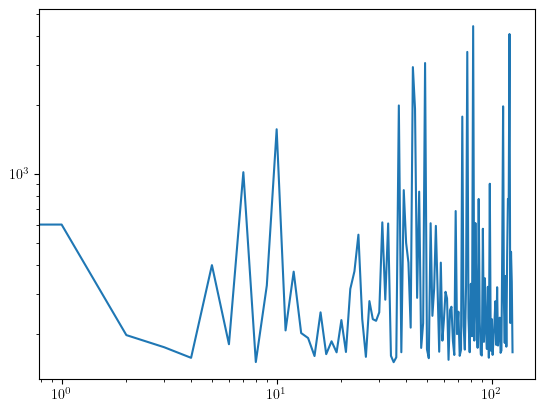

In [1528]:
plt.loglog(save_a)

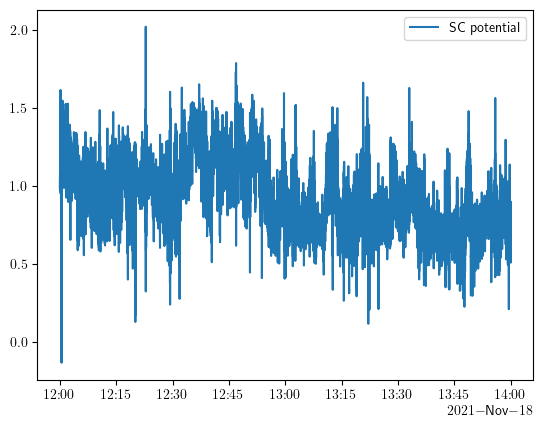

In [1529]:
plt.plot(res[0]['v_sc'], label = 'SC potential')
plt.legend()

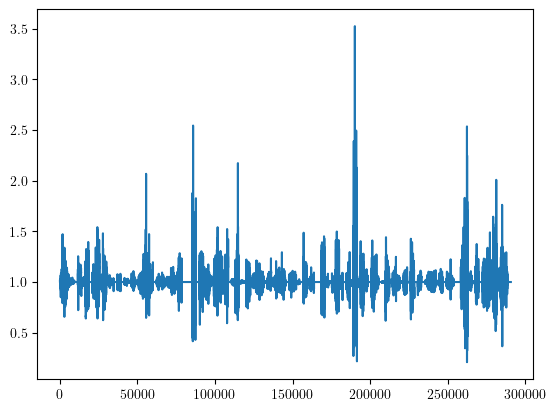

In [1530]:
plt.plot(Fs)

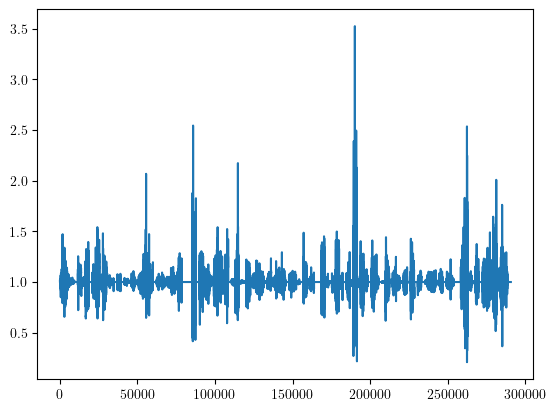

In [1531]:
plt.plot(Fs)

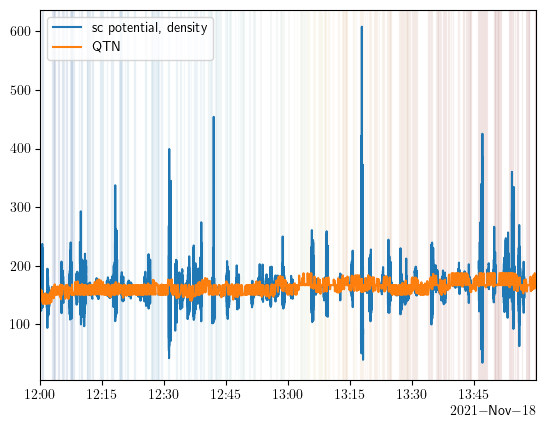

In [1532]:
c = figs.create_colors(len(qtn_gaps))
for i in range(len(qtn_gaps)):
    plt.axvspan(qtn_gaps['Start'][i],qtn_gaps['End'][i], alpha=0.1, color=c[i])

plt.plot(res[0]['sc_pot_dens'], label ='sc potential, density')

plt.plot(fin['Par']['V_resampled']['np'], label ='QTN')

#plt.plot(fin['pot_dens']["sc_pot_dens"])

plt.xlim([fin['Mag']['B_resampled'].index[0], fin['Mag']['B_resampled'].index[-1]])

plt.legend()

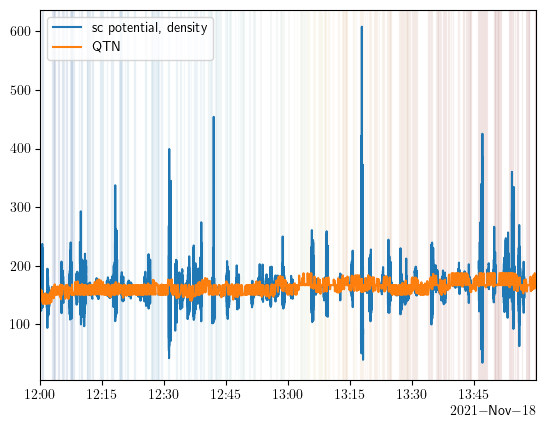

In [1533]:
c = figs.create_colors(len(qtn_gaps))
for i in range(len(qtn_gaps)):
    plt.axvspan(qtn_gaps['Start'][i],qtn_gaps['End'][i], alpha=0.1, color=c[i])

plt.plot(res[0]['sc_pot_dens'], label ='sc potential, density')

plt.plot(fin['Par']['V_resampled']['np'], label ='QTN')

#plt.plot(fin['pot_dens']["sc_pot_dens"])

plt.xlim([fin['Mag']['B_resampled'].index[0], fin['Mag']['B_resampled'].index[-1]])

plt.legend()

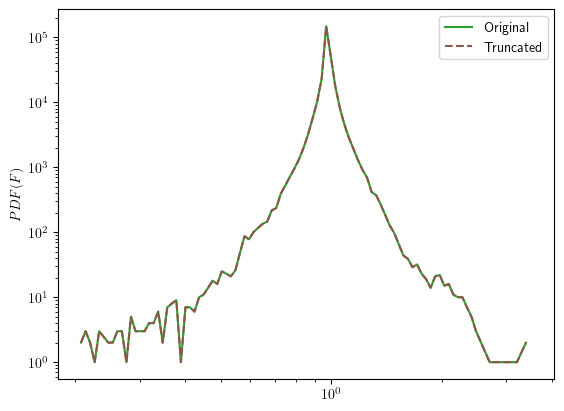

In [1534]:
r = func.pdf(Fs, 100, loglog=1,  density=0)

plt.loglog(r[0], r[1], label ='Original')

r = func.pdf( Fs_cor, 100, loglog=1, density=0)
plt.loglog(r[0], r[1], ls='--', label ='Truncated')

plt.ylabel(r'$PDF(F)$')
plt.legend()

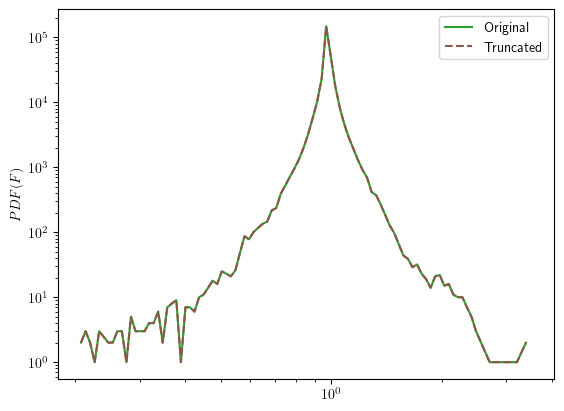

In [1535]:
r = func.pdf(Fs, 100, loglog=1,  density=0)

plt.loglog(r[0], r[1], label ='Original')

r = func.pdf( Fs_cor, 100, loglog=1, density=0)
plt.loglog(r[0], r[1], ls='--', label ='Truncated')

plt.ylabel(r'$PDF(F)$')
plt.legend()

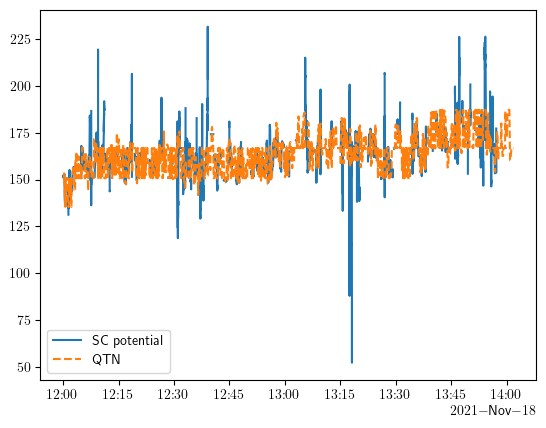

In [1536]:
ww = '10s'
plt.plot(res[0]['sc_pot_dens'].rolling(ww, center = True).median(), label  = 'SC potential')
plt.plot(res[1].rolling(ww, center = True).median(), ls='--', label  = 'QTN')

plt.legend()

In [1537]:
vv = res[0]['sc_pot_dens']
#vv = fin['np_sc_pot']['dens_df']


sc_pot = pd.DataFrame(vv).dropna()#pd.DataFrame(fin["pot_dens"]['sc_pot_dens']).dropna()
np_qtn = pd.DataFrame(fin['Par']['V_resampled']['np']).dropna()

res2 = turb.TracePSD(np_qtn.dropna().values.T[0],np_qtn.dropna().values.T[0],np_qtn.dropna().values.T[0],  func.find_cadence(pd.DataFrame(np_qtn)))

res3  = turb.TracePSD(sc_pot.values.T[0],
                      sc_pot.values.T[0],
                      sc_pot.values.T[0],  func.find_cadence(sc_pot))

In [1538]:
Bmag = np.sqrt(fin['Mag']['B_resampled']['Bx']**2 + fin['Mag']['B_resampled']['By']**2 + fin['Mag']['B_resampled']['Bz']**2).values

In [1539]:
bmag = turb.TracePSD(Bmag, Bmag, Bmag, func.find_cadence(fin['Mag']['B_resampled']))

Text(0, 0.5, '$PSD$')

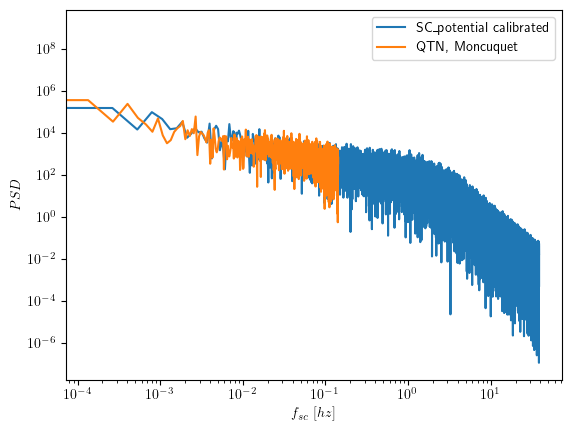

In [1540]:

plt.loglog(res3[0], res3[1], label = 'SC_potential calibrated')
plt.loglog(res2[0], res2[1], label = 'QTN, Moncuquet')
plt.legend()
plt.xlabel(r'$f_{sc}~[hz]$')
plt.ylabel(r'$PSD$')

In [1541]:
sm_bmag  = func.smoothing_function(bmag[0], bmag[1]/3)

In [1542]:
sm3 = func.smoothing_function(res3[0], res3[1])


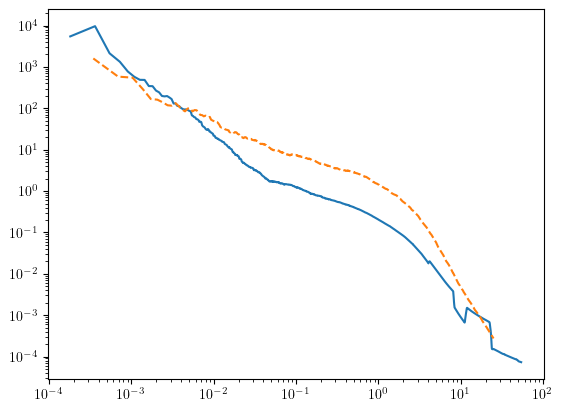

In [1543]:
plt.loglog(sm_bmag[0], sm_bmag[1], label = 'SC_potential calibrated')
plt.loglog(sm3[0], sm3[1]/100, ls='--')

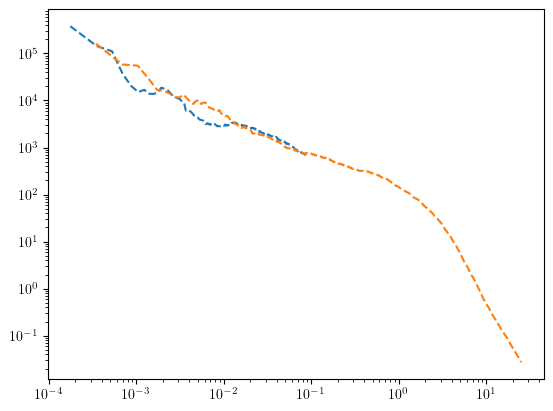

In [1544]:

sm2  = func.smoothing_function(res2[0], res2[1])

sm3 = func.smoothing_function(res3[0], res3[1])


plt.loglog(sm2[0], sm2[1], ls='--')
plt.loglog(sm3[0], sm3[1], ls='--')

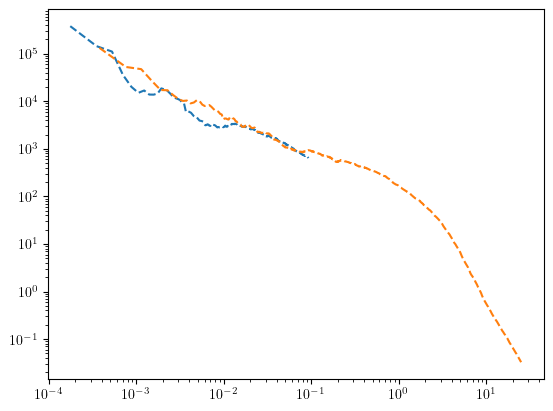

In [1525]:
sm2  = func.smoothing_function(res2[0], res2[1])

sm3 = func.smoothing_function(res3[0], res3[1])


plt.loglog(sm2[0], sm2[1], ls='--')
plt.loglog(sm3[0], sm3[1], ls='--')

# Visualize data from downloaded interval

In [ ]:
# user defined parameters
sc                = 'PSP'
label_size        = 21                                    # labels etc

n_subplots        = 7                                     # number os subplots
my_dir            = '/Users/nokni/work/MHDTurbPy/examples/' #
format_2_return   = "%Y_%m_%d"                            # Format to save figures


figs.visualize_downloaded_intervals(
                                  sc                         ,
                                  fin['Par']['V_resampled'],
                                  fin['Mag']['B_resampled'],
                                  sig     ,
                                  my_dir,
                                  format_2_return  = "%Y_%m_%d",  #
                                  size             = label_size,
                                  numb_subplots    = n_subplots
                                 )



# Estimate Power Spectral Density (PSD) of the magnetic field.
 - When using high resolution data, 'smoothing_function' is going to be slow!

In [ ]:
fig, ax =figs.initializeFigure(r'$PSD ~[nT^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig'], label ='Trace')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_R'], label ='R comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_T'], label ='T comp')
plt.loglog(fin['Mag']['f_B_orig'], fin['Mag']['PSD_f_orig_N'], label ='N comp')

plt.legend()

# Smooth and fit the PSD

In [ ]:
# Define fit range
x0, xf = 8e-4, 1e-2


# Initialize figure
fig, ax =figs.initializeFigure(r'$PSD ~[(km/s)^{2}~ hz^{-1}]$', r'$f_{sc} ~[hz]$')


# Smooth the PSD using a window of 2
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])



# Estimate fit 
fit, s, e, x, y = func.find_fit(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'], x0, xf)


# Add legend
lab_name =r'$\propto f^{ {%.2f}  \pm \ {%.2f}  }$'  %(round(fit[0][1],2), round(np.sqrt(fit[1][1][1]),2))


# Plot everything
plt.loglog(fin['Par']['dict_psd']['f_zpm'], fin['Par']['dict_psd']['psd_v'])
plt.loglog(sm[0], sm[1], label ='smoothed')
plt.loglog(x[s:e],5*fit[2], 'k-.', lw=1.2, ls='-',label=lab_name) 



plt.legend(frameon=0)


# Plot normalized cross helicity and residual energy spectrum

In [ ]:
fig, ax =figs.initializeFigure(r'', r'$f_{sc} ~[hz]$')


zp = fin['Par']['dict_psd']['psd_zp']
zm = fin['Par']['dict_psd']['psd_zm']

va = fin['Par']['dict_psd']['psd_b']
v  = fin['Par']['dict_psd']['psd_v']

plt.yscale('linear')
plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm), label =r'$\sigma_c$')
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], (zp-zm)/(zp+zm))
plt.semilogx(sm[0], sm[1],c='k')

plt.semilogx(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va), alpha=0.5,  label =r'$\sigma_r$')
sm = func.smoothing_function(fin['Par']['dict_psd']['f_zpm'], (v-va)/(v+va))
plt.semilogx(sm[0], sm[1],c='k')

# Smooth the PSD using a window of 2

plt.axvline(fin['Par']['dict_psd']['f_zpm'][ind[0]])
plt.axhline(y=0)
plt.legend(frameon=0)

#  Estimate PVI Timeseries

In [ ]:
# User defined parameters
hours                  = 4                             # Averaging window in denominator (Hours)
hmany                  = [5, 100, 500]               # Estimate PVI timeseries using a lag of \ell =hmany*di
taus                   = None
B_df                   = fin['Mag']['B_resampled']
V_df                   = fin['Par']['V_resampled']

#
di                     = fin['Par']['di_mean']       # Mean value of ion inertial length for the interval
Vsw                    = fin['Par']['Vsw_mean']      # Mean value of Solar wind speed  for the interval

# Define figure labels
ylabel, xlabel         = r'$PVI$',  r"$Date$"
inset_f_size           = 7



# Run function
PVI_ts                 =turb.estimate_PVI(B_df,
                                           hmany, 
                                           taus,
                                           di,
                                           Vsw,
                                           hours,
                                           PVI_vec_or_mod='vec'
                                          )



# init Figure
fig, ax  = figs.initializeFigure(ylabel, xlabel, '1col')

for kk in range(len(hmany)):
    ax.plot(PVI_ts['PVI_'+str(hmany[kk])], ls='-', ms=0, lw=0.1, label =r'$PVI(\ell= {%d} d_{i})$'%(hmany[kk]))
    
    # # Estimate PDF of PVI
    # res =func.pdf(PVI_ts['PVI_'+str(hmany[kk])].dropna().values, nbins, loglog, density)
    # ax2.semilogy(res[0], res[1], ls='-', ms=0, lw=0.1,c ='C'+str(kk))
    # ax2.set_ylabel(r'$p(PVI)$')
    # ax2.set_ylabel(r'$PVI$')
    


ax.legend(loc=0, )
ax.set_ylim([0,None])


# Superposed epoch analysis
- For more information check (https://github.com/nsioulas/SEA)


In [ ]:
# user defined parameters
time_around        = '1000s'   # Time around identified events
which_one          =  'Vth'    # Parameter to be plotted on y axis
mean_or_median     =  0        # Estimate mean (1) or median (0) of events
resample_rate      =  '800ms'  # Cadence of joined timeseries
which_one_2_plot   = 0 


# you can actually aplly multiple conditions
condit_variables   = ['PVI_500']#, 'sigma_r']
conditions         = [['>=']]#, ['>=','<='] ]
threshold_values   = [[1]]#, [-0.15, 0.1]]


ylabel, xlabel     = r'$V_{th} ~[km/s]$',  r"$\delta \ell ~[d_i]$"


# Merge the two dfs
f_df = PVI_ts.resample(resample_rate ).mean().join(
     V_df.resample(resample_rate ).mean()
)


# run SEA function
results  = SEA(f_df,
              condit_variables,
              threshold_values,
              conditions,
              time_around,
              which_one,
              mean_or_median,
              resample_rate)


# Assign
keys =list(results.keys())
xvals, yvals, y_std, y_std_err_mean = results[keys[which_one_2_plot]]


# convert temporal lag to spatial and normalize with di
di_lag    = Vsw*xvals/di

# init Figure
fig, ax   = figs.initializeFigure(ylabel, xlabel, '1col')

ax.plot(di_lag, yvals, ls='-', ms=0, lw=0.1)
    

In [ ]:
it doesnt matter put me on priority:
there seems to be something in the code that does not really make sense. Lets get this from scratch.

We need to calibrate the data of one timeseries using the lower-cadence timeseries. What is the optimal way of doing this without introducing aliasing. USE KNOWELDGE OF REAL WORLD AMND REVISE FUNCTIOJN

I have already provided a verison of the function. THINK DEEPLY AND REVISE TO ACHIEVCE MY GOALS OF calibrating the data of a high frequency timeseties with a lower cadence timesetis and avoid aliasing and sideeffects. YOU CAN revise the functions as much as you need

Objective:
Develop a function that calibrates high-frequency spacecraft potential data using lower-frequency QTN density measurements. The function must ensure that high-frequency fluctuations do not influence the calibration process by applying a low-pass filtering step before fitting and then applying the calibration to the full-resolution data. The function should return the calibrated high-frequency density along with diagnostic outputs.

Function Requirements:
Input Data:

df_highfreq: High-frequency spacecraft potential data.
df_qtn: Lower-frequency QTN density data.
Both datasets have a datetime index.
Step 1: Synchronization

Align the two datasets in time using synchronize_dfs().
Ensure that the QTN density and spacecraft potential share the same time axis.
If est_roll_med=True, apply a rolling median to smooth the QTN density before synchronization.
Step 2: Low-Pass Filtering (Pre-Fitting)

Apply a low-pass filter to both synchronized datasets before segmenting them for fitting.
The cutoff frequency is determined by the user-defined averaging window (lp_window), which is converted to:
𝑓
cutoff
=
1
lp_window in seconds
f 
cutoff
​
 = 
lp_window in seconds
1
​
 
This step ensures that only the low-frequency trend is used for calibration.
Step 3: Segmentation and Calibration

Break the pre-filtered synchronized data into time intervals (interval_size).
Within each interval, fit the model:
𝑛
=
𝑎
⋅
exp
⁡
(
𝑏
⋅
(
𝑉
+
𝑐
)
)
n=a⋅exp(b⋅(V+c))
using only the pre-filtered potential and QTN density.
Store the calibration coefficients 
𝑎
,
𝑏
,
𝑐
a,b,c and their errors.
Step 4: Apply Calibration to the Full-Resolution Data

Retrieve the original full-resolution potential for each interval.
Compute its low-frequency component 
𝑉
low
V 
low
​
  by applying the same low-pass filter.
Compute the high-frequency residual:
𝛿
𝑉
=
𝑉
full
−
𝑉
low
δV=V 
full
​
 −V 
low
​
 
Compute the low-frequency calibrated density:
𝑛
slow
=
𝑎
⋅
exp
⁡
(
𝑏
⋅
(
𝑉
low
+
𝑐
)
)
n 
slow
​
 =a⋅exp(b⋅(V 
low
​
 +c))
Compute the correction factor:
𝐹
=
exp
⁡
(
𝑏
⋅
𝛿
𝑉
)
F=exp(b⋅δV)
Clip 
𝐹
F to prevent excessive amplification: F_{\text{corr}} = \text{clip}(F, \text{clip_coeffs}[0], \text{clip_coeffs}[1])
Compute the final calibrated density:
𝑛
cal
=
𝑛
slow
×
𝐹
corr
n 
cal
​
 =n 
slow
​
 ×F 
corr
​
 
Step 5: Return the Outputs

The function should return:
A DataFrame with the full-resolution calibrated density (sc_pot_dens).
The synchronized QTN density data.
Lists of estimated calibration coefficients (
𝑎
,
𝑏
,
𝑐
a,b,c).
Lists of their corresponding error estimates.
The processed full-resolution spacecraft potential.
Intermediate diagnostic values (V_low, delta_V, F, F_corr).
Final Expectations
The function should minimize unnecessary new dataframe creations.
The synchronization step should happen only once.
The low-pass filtering should be applied only once before fitting.
The fitting should be performed only on smoothed data, but the final calibration should be applied to the original full-resolution potential.
The correction factor 
𝐹
F should be clipped to avoid amplifying high-frequency noise.
This approach ensures that the calibration is robust, avoids aliasing, and does not introduce artifacts when applied to high-frequency data.

import numpy as np
import pandas as pd
import traceback
from astropy import units as u
import ssqueezepy
import scipy
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from datetime import datetime
from pathlib import Path
import pickle
from scipy import stats
import numba
from numba import jit, njit, prange, objmode
from scipy.optimize import curve_fit, least_squares
import joblib
from joblib import Parallel, delayed
import statistics
from statistics import mode
import orderedstructs
import sys

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func

##########################################
# 1. Process Spacecraft Potential Function
##########################################
def process_sc_pot(df, voltage_columns=None):
    """
    Processes a DataFrame to compute an averaged signal from voltage columns 
    and return the result as a DataFrame with the same datetime index.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with a datetime index and voltage columns.
        voltage_columns (list of str, optional): List of voltage column names. 
            If None, all columns containing 'V' in their name are used.
    
    Returns:
        pd.DataFrame: DataFrame containing the computed v_sc signal with the original datetime index.
    """
    if voltage_columns is None:
        voltage_columns = [col for col in df.columns if 'V' in col]
    v_sc = -np.nanmean(df[voltage_columns], axis=1)
    return pd.DataFrame(v_sc, index=df.index, columns=['v_sc'])

##########################################
# 2. Robust Fitting Function
##########################################
import numpy as np
from scipy import stats
from scipy.optimize import least_squares

def fit_single_exponential_with_outliers(x, y, n_sigma=3, max_iter=5):
    """
    Fit the model: y = a * exp(b*(x+c))
    using a robust least-squares optimizer (in log-space) with iterative sigma clipping,
    then perform a final refit using linear loss to obtain a reliable covariance matrix.
    
    Parameters
    ----------
    x : np.ndarray
        Independent variable array.
    y : np.ndarray
        Dependent variable array.
    n_sigma : float, optional
        Sigma-clipping threshold in log-space (default is 3).
    max_iter : int, optional
        Maximum number of sigma-clipping iterations (default is 5).
    
    Returns
    -------
    a : float
        Fitted amplitude.
    b : float
        Fitted exponential coefficient.
    c : float
        Fitted horizontal offset.
    perr : np.ndarray
        Estimated standard errors [err_a, err_b, err_c].
    """
    # Clean up the data
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    valid = (y > 0) & np.isfinite(y) & np.isfinite(x)
    x_clean = x[valid]
    y_clean = y[valid]
    if x_clean.size < 3:
        raise ValueError("Not enough valid points to fit the model.")
    
    # Define the residual function in log-space
    def residuals(params, t, y_obs):
        a, b, c = params
        return np.log(y_obs) - (np.log(a) + b * (t + c))
    
    # Initial estimates via linear regression in log-space:
    log_y = np.log(y_clean)
    slope, intercept, _, _, _ = stats.linregress(x_clean, log_y)
    
    # Use median to center x for better decoupling of parameters
    median_x = np.median(x_clean)
    x_std = np.std(x_clean)
    c_initial = -median_x
    a_initial = np.exp(intercept - slope * c_initial)
    
    # Set adaptive bounds for parameter 'c'
    # Ensure the bound range is wide enough to include c_initial.
    c_bound_range = max(5 * x_std, 2 * abs(median_x), 1.0)
    c_lower, c_upper = -c_bound_range, c_bound_range

    # Set bounds for parameter 'a' (must be positive)
    a_lower, a_upper = 1e-12, np.inf

    # Set adaptive bounds for parameter 'b'
    if np.abs(slope) < 1e-6:
        b_lower, b_upper = -10, 10
    else:
        factor = 5
        b_lower, b_upper = slope - factor * np.abs(slope), slope + factor * np.abs(slope)
        b_lower = max(b_lower, -10)
        b_upper = min(b_upper, 10)
    # Clip the initial guess for b to be within bounds
    b_initial = np.clip(slope, b_lower, b_upper)
    
    # Compose the initial guess vector
    initial_guess = [a_initial, b_initial, c_initial]
    
    # Define the overall bounds for all parameters
    lower_bounds = [a_lower, b_lower, c_lower]
    upper_bounds = [a_upper, b_upper, c_upper]
    
    # Begin iterative sigma clipping
    inliers = np.ones(len(x_clean), dtype=bool)
    popt = None
    for ii in range(max_iter):
        result = least_squares(
            residuals,
            x0=initial_guess if popt is None else popt,
            args=(x_clean[inliers], y_clean[inliers]),
            loss='soft_l1',
            bounds=(lower_bounds, upper_bounds)
        )
        if not result.success:
            raise ValueError(f"Robust least squares fitting did not converge in iteration {ii}")
        popt = result.x
        resid_all = residuals(popt, x_clean, y_clean)
        
        # Compute robust scale estimate using MAD
        mad = np.median(np.abs(resid_all - np.median(resid_all)))
        robust_std = 1.4826 * mad if mad > 0 else np.std(resid_all)
        
        new_inliers = np.abs(resid_all) < (n_sigma * robust_std)
        
        # Check if inliers have converged; also ensure enough points remain
        if np.array_equal(new_inliers, inliers):
            inliers = new_inliers
            break
        inliers = new_inliers
        if np.sum(inliers) < 3:
            raise ValueError("Too many outliers removed; not enough points remain for a robust fit.")
    
    # Final fit with linear loss to obtain a reliable covariance matrix
    result_final = least_squares(
        residuals,
        x0=popt,
        args=(x_clean[inliers], y_clean[inliers]),
        loss='linear',
        bounds=(lower_bounds, upper_bounds)
    )
    if not result_final.success:
        raise ValueError("Final least squares fitting did not converge.")
    
    popt = result_final.x
    a, b, c = popt
    
    # Estimate covariance matrix from the Jacobian at the solution
    dof = max(len(result_final.fun) - len(popt), 1)
    s_sq = 2 * result_final.cost / dof  # cost is half the sum of squares
    J = result_final.jac
    JTJ = J.T.dot(J)
    cov = np.linalg.pinv(JTJ) * s_sq
    perr = np.sqrt(np.diag(cov))
    
    return a, b, c, perr

##########################################
# 3. Low-Pass Filter Function
##########################################
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff, fs, order=4):
    """
    Apply a low-pass Butterworth filter to the data.
    
    Parameters:
        data (array_like): Input signal.
        cutoff (float): Cutoff frequency in Hz.
        fs (float): Sampling frequency of the data in Hz.
        order (int): Filter order.
    
    Returns:
        np.ndarray: The filtered data, or the original data if too short for filtering.
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    padlen = 3 * (max(len(b), len(a)) - 1)
    if len(data) <= padlen:
        return data
    filtered = filtfilt(b, a, data)
    return filtered

##########################################
# 4. Revised Calibration Function
##########################################
def calibrate_highfreq_in_intervals(
    df_highfreq,        # Original high-frequency DataFrame
    df_qtn,             # QTN DataFrame (lower-frequency reference)
    interval_size='4min',
    col_sc_pot='v_sc',  # Column in df_highfreq with spacecraft potential
    rol_med_wind='30s',
    est_roll_med=True,
    n_sigma=3,
    clip_coeffs = [0.6, 1.2],
    max_iter=10000,
    fs=256,             # Sampling frequency of high-frequency data (Hz)
    cutoff=None         # Calibration cutoff frequency (Hz); if None, it is computed from synchronized cadence.
):
    """
    Calibrates high-frequency spacecraft potential data using lower-frequency QTN density
    measurements. In each interval, the calibration mapping
         n = a * exp(b*(V + c))
    is determined using the synchronized data. To avoid aliasing when applying the calibration
    to high-frequency data, the full-resolution potential is decomposed into a low-frequency (calibrated)
    component and a high-frequency residual. The low-frequency calibrated density is computed as
         n_slow = a * exp(b*(V_low + c))
    and then a nonlinear correction is applied:
         n_cal = n_slow * exp(b*delta_V)
    To avoid over-amplification of high-frequency noise (which may lead to aliasing), the correction factor
    is clipped to a narrow range (e.g. [0.9, 1.1]). This yields:
         n_cal = n_slow * clip(exp(b*delta_V), 0.9, 1.1)
    
    This approach uses the low-frequency calibration coefficients while limiting the impact of high-frequency fluctuations.
    
    Parameters
    ----------
    df_highfreq : pd.DataFrame
        High-frequency data with a DateTime index containing col_sc_pot.
    df_qtn : pd.DataFrame
        DataFrame with a DateTime index containing QTN density data.
    interval_size : str or pd.Timedelta
        Non-overlapping chunk size, e.g., "4min".
    col_sc_pot : str
        Column name for the spacecraft potential in df_highfreq.
    rol_med_wind : str
        Window length for rolling median (if est_roll_med is True).
    est_roll_med : bool
        Whether to apply a rolling median on the QTN data prior to synchronization.
    n_sigma : float
        Sigma-clipping threshold (default=3).
    max_iter : int
        Maximum outlier-removal iterations (default=10000).
    fs : float
        Sampling frequency of the high-frequency data in Hz.
    cutoff : float or None
        Cutoff frequency for the low-pass filter in Hz. If None, it is computed as 
        1.15*(fs_sync/2), where fs_sync is the sampling frequency of the synchronized data.
    
    Returns
    -------
    df_out : pd.DataFrame
        High-frequency data with an added column "sc_pot_dens" containing the calibrated density.
    df_qtn_sync : pd.DataFrame
        The synchronized QTN DataFrame.
    save_a : list
        List of fitted amplitude coefficients for each interval.
    save_b : list
        List of fitted exponential coefficients for each interval.
    save_c : list
        List of fitted offset coefficients for each interval.
    save_err_a : list
        List of error estimates for coefficient a for each interval.
    save_err_b : list
        List of error estimates for coefficient b for each interval.
    save_err_c : list
        List of error estimates for coefficient c for each interval.
    df_highfreq_processed : pd.DataFrame
        The processed high-frequency data (with column 'v_sc').
    """
    # Process the spacecraft potential at full resolution.
    df_highfreq_processed = process_sc_pot(df_highfreq)
    
    # Synchronize using the (potentially downsampled) data.
    if est_roll_med:
        df_high_sync, df_qtn_sync = func.synchronize_dfs(
            pd.DataFrame(df_highfreq_processed),
            pd.DataFrame(df_qtn).rolling(rol_med_wind, center=True).median(),
            False
        )
    else:
        df_high_sync, df_qtn_sync = func.synchronize_dfs(
            pd.DataFrame(df_highfreq_processed),
            pd.DataFrame(df_qtn),
            False
        )
    
    # Prepare output DataFrame (full resolution).
    df_out = df_highfreq_processed.copy()
    df_out["sc_pot_dens"] = np.nan
    
    interval_size = pd.Timedelta(interval_size)
    if len(df_high_sync) < 2:
        return df_out, df_qtn_sync, [], [], [], [], [], [], df_highfreq_processed
    
    t_min = df_high_sync.index[0]
    t_max = df_high_sync.index[-1]
    current_start = t_min
    
    save_a = []
    save_b = []
    save_c = []
    save_err_a = []
    save_err_b = []
    save_err_c = []
    Fs         = []
    Fs_cor     = []
    V_lows, delta_Vs = [], []
    
    
    # Determine sampling frequencies.
    fs_full = 1 / func.find_cadence(df_highfreq_processed)
    fs_sync = 1 / func.find_cadence(df_high_sync)
    if cutoff is None:
        cutoff = 1.15* (fs_sync / 2)  # Use a margin on the Nyquist frequency of the synchronized data.
    
    while current_start < t_max:
        current_end = current_start + interval_size
        
        # Use the synchronized (low-frequency) data for fitting.
        chunk_sync_hf = df_high_sync.loc[current_start:current_end]
        chunk_sync_qn = df_qtn_sync.loc[current_start:current_end]
        if len(chunk_sync_hf) < 2 or len(chunk_sync_qn) < 2:
            current_start = current_end
            continue
        
        x = chunk_sync_hf[col_sc_pot].values
        y = chunk_sync_qn.values.ravel()
        
        try:
            a, b, c, err = fit_single_exponential_with_outliers(x, y, n_sigma=n_sigma, max_iter=max_iter)
        except ValueError:
            current_start = current_end
            continue
        
        # Use the full-resolution potential from df_highfreq_processed for calibration.
        hf_chunk = df_highfreq_processed.loc[current_start:current_end, col_sc_pot].values
        
        # Decompose the full-resolution potential:
        V_low   = lowpass_filter(hf_chunk, cutoff, fs_full)
        delta_V = hf_chunk - V_low
        
        # Compute the calibrated low-frequency density.
        n_slow = a * np.exp(b * (V_low + c))
        # Compute full correction factor F = exp(b * delta_V)
        F = np.exp(b * delta_V)
        # To avoid over–amplification of high-frequency noise, clip F to a reasonable range.
        #F_corr = np.clip(F, 0.9, 1.1)

        F_outliers   = np.abs(np.nanmedian(F) + np.nanstd(F))
        print('F, std', F_outliers )
        
        #F_corr = np.clip(F, clip_coeffs[0], F_outliers)
        F_corr = np.clip(F, clip_coeffs[0],clip_coeffs[1])
        n_cal = n_slow * F_corr
        
        # Assign the calibrated density to the output.
        df_out.loc[current_start:current_end, "sc_pot_dens"] = pd.Series(n_cal, index=df_out.loc[current_start:current_end].index)
        
        save_a.append(a)
        save_b.append(b)
        save_c.append(c)
        save_err_a.append(err[0])
        save_err_b.append(err[1])
        save_err_c.append(err[2])
        V_lows.append(V_low)
        delta_Vs.append(delta_V)
        Fs.append(F)
        Fs_cor.append(F_corr)
        
        current_start = current_end
    
    if "v_sc" in df_out.columns:
        del df_out["v_sc"]
    
    return (df_out, df_qtn_sync, save_a, save_b, save_c,
            save_err_a, save_err_b, save_err_c, df_high_sync, np.hstack(Fs), np.hstack(Fs_cor), np.hstack(V_lows), np.hstack(delta_Vs))